# **Laboratorio 11: LLM y Agentes Autónomos 🤖**

MDS7202: Laboratorio de Programación Científica para Ciencia de Datos

### **Cuerpo Docente:**

- Profesores: Ignacio Meza, Sebastián Tinoco
- Auxiliar: Eduardo Moya
- Ayudantes: Nicolás Ojeda, Melanie Peña, Valentina Rojas

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados

- Nombre de alumno 1: Martín Torrico
- Nombre de alumno 2: Alejandra Toro


### **Link de repositorio de GitHub:** [Insertar Repositorio](https://github.com/MartinTorricoP/Laboratorios_MDS7202)

## **Temas a tratar**

- Reinforcement Learning
- Large Language Models

## **Reglas:**

- **Grupos de 2 personas**
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Prohibidas las copias.
- Pueden usar cualquer matrial del curso que estimen conveniente.

### **Objetivos principales del laboratorio**

- Resolución de problemas secuenciales usando Reinforcement Learning
- Habilitar un Chatbot para entregar respuestas útiles usando Large Language Models.

El laboratorio deberá ser desarrollado sin el uso indiscriminado de iteradores nativos de python (aka "for", "while"). La idea es que aprendan a exprimir al máximo las funciones optimizadas que nos entrega `pandas`, las cuales vale mencionar, son bastante más eficientes que los iteradores nativos sobre DataFrames.

## **1. Reinforcement Learning (2.0 puntos)**

En esta sección van a usar métodos de RL para resolver dos problemas interesantes: `Blackjack` y `LunarLander`.

In [2]:
!pip install -qqq gymnasium stable_baselines3
!pip install -qqq swig
!pip install -qqq gymnasium[box2d]

ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (box2d-py)


### **1.1 Blackjack (1.0 puntos)**

<p align="center">
  <img src="https://www.recreoviral.com/wp-content/uploads/2016/08/s3.amazonaws.com-Math.gif"
" width="400">
</p>

La idea de esta subsección es que puedan implementar métodos de RL y así generar una estrategia para jugar el clásico juego Blackjack y de paso puedan ~~hacerse millonarios~~ aprender a resolver problemas mediante RL.

Comencemos primero preparando el ambiente. El siguiente bloque de código transforma las observaciones del ambiente a `np.array`:


In [3]:
import gymnasium as gym
from gymnasium.spaces import MultiDiscrete
import numpy as np

class FlattenObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super(FlattenObservation, self).__init__(env)
        self.observation_space = MultiDiscrete(np.array([32, 11, 2]))

    def observation(self, observation):
        return np.array(observation).flatten()

# Create and wrap the environment
env = gym.make("Blackjack-v1")
env = FlattenObservation(env)

#### **1.1.1 Descripción de MDP (0.2 puntos)**

Entregue una breve descripción sobre el ambiente [Blackjack](https://gymnasium.farama.org/environments/toy_text/blackjack/) y su formulación en MDP, distinguiendo de forma clara y concisa los estados, acciones y recompensas.


El ambiente de Blackjack adjunto consiste en una partida de Blackjack, juego donde el objetivo es que la suma de tus cartas se mayor a la del dealer sin excederse de los 21 puntos. La formulación en MDP corresponde a :

* Estados:
  - Suma actual de las cartas del jugador: Valores entre el 4 al 21.
  - Carta visible del dealer: Valores del 1 al 10 (donde 1 es un As).
  - As utilizable: Valor 0 o 1 (siendo 1 cuando el jugador puede utilizar un As).

* Acciones:
 - Quedarse con la suma actual: 0 (stick).
 - Pedir otra carta: 1 (hit).

* Recompensas:
 - Ganar: +1.
 - Perder: -1.
 - Empatar: 0.
 - Ganar con blackjack natural: +1,5 (solo si natural=True).



#### **1.1.2 Generando un Baseline (0.2 puntos)**

Simule un escenario en donde se escojan acciones aleatorias. Repita esta simulación 5000 veces y reporte el promedio y desviación de las recompensas. ¿Cómo calificaría el performance de esta política? ¿Cómo podría interpretar las recompensas obtenidas?

In [4]:
import gymnasium as gym
import numpy as np

# Variables para almacenar resultados
rewards = []
n = 5000 #numero de repeticiones

# Simulación de 5000 episodios con acciones aleatorias
for _ in range(n):
    obs = env.reset()  # Reiniciar el ambiente
    done = False
    total = 0

    while not done:
        action = env.action_space.sample() # Seleccionar una acción aleatoria (0 o 1)
        obs, reward, done, _, _ = env.step(action) #Ejecutar la acción
        total += reward

    rewards.append(total)

# Calcular promedio y desviación estándar de las recompensas
average_reward = np.mean(rewards)
std_deviation = np.std(rewards)

print(f"Promedio de las recompensas: {average_reward}")
print(f"Desviación estándar de las recompensas: {std_deviation}")

Promedio de las recompensas: -0.407
Desviación estándar de las recompensas: 0.8922729403047029


El desempeño de la política aleatoria es subóptimo.

Esto es, ya que contamos con un promedio de recompensas negativos (-0.407), indicando más pérdidas que ganancias, sumado a una alta variabilidad con una desviación estándar de 0.8922, debido a la naturaleza estocástica del juego.

Con esta política, podemos tener un resultado base el cual podemos mejorar, mostrandonos que no es un juego donde una buena estrategia es similar a lanzar una moneda, sino que la estrategia de cuándo pedir o cuándo quedarse es importante para tener mejores resultados.

#### **1.1.3 Entrenamiento de modelo (0.2 puntos)**

A partir del siguiente [enlace](https://stable-baselines3.readthedocs.io/en/master/guide/algos.html), escoja un modelo de `stable_baselines3` y entrenelo para resolver el ambiente `Blackjack`.

In [ ]:
from stable_baselines3 import DQN

# Crear el modelo DQN
model = DQN("MlpPolicy", env, verbose=1)

# Entrenar el modelo
model.learn(total_timesteps=5000)

#### **1.1.4 Evaluación de modelo (0.2 puntos)**

Repita el ejercicio 1.1.2 pero utilizando el modelo entrenado. ¿Cómo es el performance de su agente? ¿Es mejor o peor que el escenario baseline?

In [6]:
# Evaluar la política aprendida por DQN
dqn_rewards = []

for _ in range(n):
    obs, _ = env.reset()
    done = False
    total = 0

    while not done:
        action, _ = model.predict(obs, deterministic=True)  # Política DQN
        obs, reward, done, _, _ = env.step(action)
        total += reward

    dqn_rewards.append(total)

# Calcular promedio y desviación estándar de la política DQN
average_dqn_reward = np.mean(dqn_rewards)
std_dqn_deviation = np.std(dqn_rewards)

# Comparar resultados
print("Comparación de resultados:")
print(f"Política Aleatoria \nPromedio: {average_reward}, Desviación: {std_deviation}")
print(f"Política DQN \nPromedio: {average_dqn_reward}, Desviación: {std_dqn_deviation}")


Comparación de resultados:
Política Aleatoria 
Promedio: -0.407, Desviación: 0.8922729403047029
Política DQN 
Promedio: -0.1144, Desviación: 0.9521095735260726


Podemos ver que el desempeño del agente mejora considerablemente en cuanto el promedio de sus recompensas, subiendo su promedio a -0.1144, tomando deciciones estratégicas e inteligentes y con ello ganando más veces que tomando deciciones al azar.

Sin embargo, podemos ver también que el desempeño del agente tiene más variabilidad en sus resultados con su política, lo cual nos indica que puede ser refinado para mejorar su toma de decisiones.

Con lo anterior, este escenario es mejor al aleatorio, pero sería recomendable seguir mejorando su consistencia en el desempeño.



#### **1.1.5 Estudio de acciones (0.2 puntos)**

Genere una función que reciba un estado y retorne la accion del agente. Luego, use esta función para entregar la acción escogida frente a los siguientes escenarios:

- Suma de cartas del agente es 6, dealer muestra un 7, agente no tiene tiene un as
- Suma de cartas del agente es 19, dealer muestra un 3, agente tiene tiene un as

¿Son coherentes sus acciones con las reglas del juego?

Hint: ¿A que clase de python pertenecen los estados? Pruebe a usar el método `.reset` para saberlo.

In [7]:
def elegir_accion(estado, model):
    action, _ = model.predict(estado, deterministic=True)
    return action

estado1 = [6, 7, False]
accion1 = elegir_accion(estado1, model)

estado2 = [19, 3, True]
accion2 = elegir_accion(estado2, model)

In [8]:
estado_1 = [6, 7, False]
accion_1 = elegir_accion(estado_1, model)

print(f"Acción para el estado 1 (6, 7, sin as): {'Pedir carta' if accion_1 == 1 else 'Quedarse'}")

Acción para el estado 1 (6, 7, sin as): Quedarse


In [9]:
estado_2 = [19, 3, True]
accion_2 = elegir_accion(estado_2, model)

print(f"Acción para el estado 2 (19, 3, con as): {'Pedir carta' if accion_2 == 1 else 'Quedarse'}")

Acción para el estado 2 (19, 3, con as): Quedarse


En este caso, solo el estado 2 tiene sentido, mientras que el estado 1 no tiene sentido, por lo que sería interesante poder optimizar el modelo.

Esto es porque la suma en el primer caso del agente es muy baja y sería normal pedir una sigiente carta (si no pedimos, prácticamente perdemos directamente), mientras que en el estado 2 la suma del jugador es muy alta y seguramente sobrepase el 21 (y actualmente, la carta que tiene el dealer es muy baja).




### **1.2 LunarLander**

<p align="center">
  <img src="https://i.redd.it/097t6tk29zf51.jpg"
" width="400">
</p>

Similar a la sección 2.1, en esta sección usted se encargará de implementar una gente de RL que pueda resolver el ambiente `LunarLander`.

Comencemos preparando el ambiente:


In [11]:
import gymnasium as gym
env = gym.make("LunarLander-v3", render_mode = "rgb_array", continuous = True) # notar el parámetro continuous = True

Noten que se especifica el parámetro `continuous = True`. ¿Que implicancias tiene esto sobre el ambiente?

Además, se le facilita la función `export_gif` para el ejercicio 2.2.4:

In [12]:
import imageio
import numpy as np

def export_gif(model, n = 5):
  '''
  función que exporta a gif el comportamiento del agente en n episodios
  '''
  images = []
  for episode in range(n):
    obs = model.env.reset()
    img = model.env.render()
    done = False
    while not done:
      images.append(img)
      action, _ = model.predict(obs)
      obs, reward, done, info = model.env.step(action)
      img = model.env.render(mode="rgb_array")

  imageio.mimsave("agent_performance.gif", [np.array(img) for i, img in enumerate(images) if i % 5 == 0], fps=15) # editado para mejor rendimiento

El parámetro continuous=True transforma el problema en un desafío más complejo al permitir un control más detallado del lander, lo cual también requiere métodos de aprendizaje más sofisticados.

#### **1.2.1 Descripción de MDP (0.2 puntos)**

Entregue una breve descripción sobre el ambiente [LunarLander](https://gymnasium.farama.org/environments/box2d/lunar_lander/) y su formulación en MDP, distinguiendo de forma clara y concisa los estados, acciones y recompensas. ¿Como se distinguen las acciones de este ambiente en comparación a `Blackjack`?

Nota: recuerde que se especificó el parámetro `continuous = True`

El ambiente de LunarLander consiste en un problema de control de trayectoria de un cohete, donde el objetivo es aterrizar en una plataforma sin salir del área designada ni estrellarse. La formulación en MDP corresponde a:

* Estados:
  - Coordenadas x e y del lander (posición relativa al área de aterrizaje).
  - Velocidades lineales en x e y.
  - Ángulo de orientación del lander.
  - Velocidad angular.
  - Contacto de las patas con el suelo (dos valores booleanos).

* Acciones:
  - 0: No realizar ninguna acción.
  - 1: Activar el motor lateral izquierdo.
  - 2: Activar el motor principal.
  - 3: Activar el motor lateral derecho.

* Recompensas:
- Proximidad al área de aterrizaje: Incrementos/penalizaciones por acercarse/alejarse.
- Velocidad y orientación:
  - Penalización por velocidades altas y ángulos inadecuados.
- Uso de motores:
  - Penalización por activaciones de motores -0,03 para laterales y -0,3 para el principal.
- Aterrizajes:
  - Recompensa de +10 por cada pata en contacto con el suelo.
  - Recompensa de +100 por un aterrizaje exitoso.
  - Penalización de -100 por estrellarse.
  - Un episodio se considera resuelto si el agente acumula al menos 200 puntos.

**Diferencia de acciones con Blackjack**:

A diferencia de Blackjack, donde las acciones son discretas y binarias (pedir o quedarse), en LunarLander las acciones pueden ser discretas (selección de motores) o **continuas** (intensidad de empuje), dependiendo de la configuración del ambiente.


#### **1.2.2 Generando un Baseline (0.2 puntos)**

Simule un escenario en donde se escojan acciones aleatorias. Repita esta simulación 10 veces y reporte el promedio y desviación de las recompensas. ¿Cómo calificaría el performance de esta política?

In [13]:
import gymnasium as gym
import numpy as np

# Variables para almacenar resultados
rewards = []
n = 10  # número de repeticiones

# Simulación de 10 episodios con acciones aleatorias
for _ in range(n):
    obs = env.reset()  # Reiniciar el ambiente
    done = False
    total = 0

    while not done:
        action = env.action_space.sample()  # Seleccionar una acción aleatoria
        obs, reward, done, _, _ = env.step(action)  # Ejecutar la acción
        total += reward

    rewards.append(total)

# Calcular promedio y desviación estándar de las recompensas
average_reward = np.mean(rewards)
std_deviation = np.std(rewards)

print(f"Promedio de las recompensas: {average_reward}")
print(f"Desviación estándar de las recompensas: {std_deviation}")


Promedio de las recompensas: -208.50902921506776
Desviación estándar de las recompensas: 143.06927422727438


El rendimiento de esta política aleatoria nuevamente es subóptima como es esperado.

Podemos ver que en promedio se estrella el lander 2 veces por aterrizaje, lo cual es un muy mal desempeño para lo que queremos y que tiene una desviación estándar muy alta de sus recompenzas, con un valor de 143.

Claramente hay espacio de mejora y lo desarrollaremos a continuación:



#### **1.2.3 Entrenamiento de modelo (0.2 puntos)**

A partir del siguiente [enlace](https://stable-baselines3.readthedocs.io/en/master/guide/algos.html), escoja un modelo de `stable_baselines3` y entrenelo para resolver el ambiente `LunarLander` **usando 10000 timesteps de entrenamiento**.

In [ ]:
from stable_baselines3 import PPO

# Crear el modelo PPO
model = PPO("MlpPolicy", env, verbose=1)

# Entrenar el modelo
model.learn(total_timesteps=10000)

#### **1.2.4 Evaluación de modelo (0.2 puntos)**

Repita el ejercicio 1.2.2 pero utilizando el modelo entrenado. ¿Cómo es el performance de su agente? ¿Es mejor o peor que el escenario baseline?

In [30]:
# Evaluar la política aprendida por PPO
ppo_rewards = []

for _ in range(n):
    obs, _ = env.reset()
    done = False
    total = 0

    while not done:
        action, _ = model.predict(obs, deterministic=True)  # Política PPO
        obs, reward, done, _, _ = env.step(action)
        total += reward

    ppo_rewards.append(total)

# Calcular promedio y desviación estándar de la política PPO
average_ppo_reward = np.mean(ppo_rewards)
std_ppo_deviation = np.std(ppo_rewards)

# Comparar resultados
print("Comparación de resultados:")
print(f"Política Aleatoria \nPromedio: {average_reward}, Desviación: {std_deviation}")
print(f"Política PPO \nPromedio: {average_ppo_reward}, Desviación: {std_ppo_deviation}")

Comparación de resultados:
Política Aleatoria 
Promedio: -208.50902921506776, Desviación: 143.06927422727438
Política PPO 
Promedio: -131.04745755518053, Desviación: 82.37868052944239


El performance de la gente nuevamente mejora, pero no de manera tan sustancial como en el caso del blackjack. En este caso, podemos ver que en promedio se estrella 1 vez el lander en vez de 2, lo cual es bueno, pero no óptimo. Además, viendo que su desviación tiene un valor menor, sabemos que este resultado es más consistente en el tiempo. Con esto, tenemos un mejor modelo que el baseline, pero con espacio a mejora.

#### **1.2.5 Optimización de modelo (0.2 puntos)**

Repita los ejercicios 1.2.3 y 1.2.4 hasta obtener un nivel de recompensas promedio mayor a 50. Para esto, puede cambiar manualmente parámetros como:
- `total_timesteps`
- `learning_rate`
- `batch_size`

Una vez optimizado el modelo, use la función `export_gif` para estudiar el comportamiento de su agente en la resolución del ambiente y comente sobre sus resultados.

Adjunte el gif generado en su entrega (mejor aún si además adjuntan el gif en el markdown).

In [ ]:
model = PPO("MlpPolicy", env, verbose=1, seed = 123)
model.learn(total_timesteps = 100000)

In [40]:
# Evaluar la política aprendida por PPO
ppo_opt_rewards = []

for _ in range(n):
    obs, _ = env.reset()
    done = False
    total = 0

    while not done:
        action, _ = model.predict(obs, deterministic=True)  # Política PPO
        obs, reward, done, _, _ = env.step(action)
        total += reward

    ppo_opt_rewards.append(total)

# Calcular promedio y desviación estándar de la política PPO
average_ppo_opt_reward = np.mean(ppo_opt_rewards)
std_ppo_opt_deviation = np.std(ppo_opt_rewards)

# Comparar resultados
print("Comparación de resultados:")
print(f"Política Aleatoria \nPromedio: {average_reward}, Desviación: {std_deviation}")
print(f"Política PPO \nPromedio: {average_ppo_reward}, Desviación: {std_ppo_deviation}")
print(f"Política PPO Optimizado \nPromedio: {average_ppo_opt_reward}, Desviación: {std_ppo_opt_deviation}")

Comparación de resultados:
Política Aleatoria 
Promedio: -208.50902921506776, Desviación: 143.06927422727438
Política PPO 
Promedio: -131.04745755518053, Desviación: 82.37868052944239
Política PPO Optimizado 
Promedio: 166.15260113088635, Desviación: 83.67149751757806


Finalmente, añadiendo más timesteps al entrenamiento, el modelo optimizado toma un promedio positivo, lo cual es un resultado bastante bueno en base a nuestro sistema de recompensas. Notamos que la desviación se mantiene similar al modelo sin optimizar, por lo que tiene una robustez similar en sus resultados (es una buena noticia también, ya que no perdemos consistencia a cambio de mejores resultados promedio).

In [41]:
export_gif(model, 5)

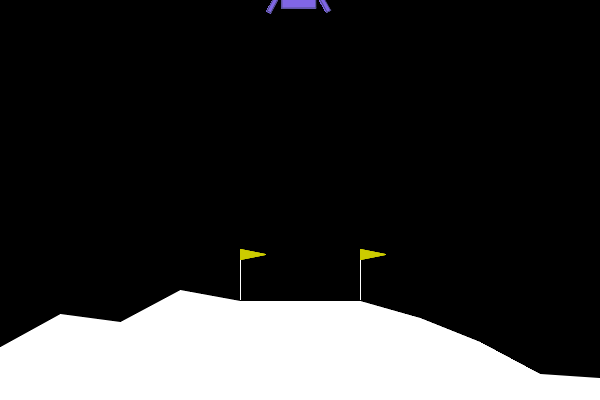

In [43]:
from IPython.display import Image
Image(open('agent_performance.gif','rb').read())

## **2. Large Language Models (4.0 puntos)**

En esta sección se enfocarán en habilitar un Chatbot que nos permita responder preguntas útiles a través de LLMs.

### **2.0 Configuración Inicial**

<p align="center">
  <img src="https://media1.tenor.com/m/uqAs9atZH58AAAAd/config-config-issue.gif"
" width="400">
</p>

Como siempre, cargamos todas nuestras API KEY al entorno:

In [20]:
import getpass
import os

if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google AI API key: ")

if "TAVILY_API_KEY" not in os.environ:
    os.environ["TAVILY_API_KEY"] = getpass.getpass("Enter your Tavily API key: ")

### **2.1 Retrieval Augmented Generation (1.5 puntos)**

<p align="center">
  <img src="https://y.yarn.co/218aaa02-c47e-4ec9-b1c9-07792a06a88f_text.gif"
" width="400">
</p>

El objetivo de esta subsección es que habiliten un chatbot que pueda responder preguntas usando información contenida en documentos PDF a través de **Retrieval Augmented Generation.**

#### **2.1.1 Reunir Documentos (0 puntos)**

Reuna documentos PDF sobre los que hacer preguntas siguiendo las siguientes instrucciones:
  - 2 documentos .pdf como mínimo.
  - 50 páginas de contenido como mínimo entre todos los documentos.
  - Ideas para documentos: Documentos relacionados a temas académicos, laborales o de ocio. Aprovechen este ejercicio para construir algo útil y/o relevante para ustedes!
  - Deben ocupar documentos reales, no pueden utilizar los mismos de la clase.
  - Deben registrar sus documentos en la siguiente [planilla](https://docs.google.com/spreadsheets/d/1Hy1w_dOiG2UCHJ8muyxhdKPZEPrrL7BNHm6E90imIIM/edit?usp=sharing). **NO PUEDEN USAR LOS MISMOS DOCUMENTOS QUE OTRO GRUPO**
  - **Recuerden adjuntar los documentos en su entrega**.

In [21]:
%pip install --upgrade --quiet PyPDF2

In [ ]:
import PyPDF2

doc_paths = [] # rellenar con los path a sus documentos

assert len(doc_paths) >= 2, "Deben adjuntar un mínimo de 2 documentos"

total_paginas = sum(len(PyPDF2.PdfReader(open(doc, "rb")).pages) for doc in doc_paths)
assert total_paginas >= 50, f"Páginas insuficientes: {total_paginas}"

#### **2.1.2 Vectorizar Documentos (0.2 puntos)**

Vectorice los documentos y almacene sus representaciones de manera acorde.

#### **2.1.3 Habilitar RAG (0.3 puntos)**

Habilite la solución RAG a través de una *chain* y guárdela en una variable.

#### **2.1.4 Verificación de respuestas (0.5 puntos)**

Genere un listado de 3 tuplas ("pregunta", "respuesta correcta") y analice la respuesta de su solución para cada una. ¿Su solución RAG entrega las respuestas que esperaba?

Ejemplo de tupla:
- Pregunta: ¿Quién es el presidente de Chile?
- Respuesta correcta: El presidente de Chile es Gabriel Boric

#### **2.1.5 Sensibilidad de Hiperparámetros (0.5 puntos)**

Extienda el análisis del punto 2.1.4 analizando cómo cambian las respuestas entregadas cambiando los siguientes hiperparámetros:
- `Tamaño del chunk`. (*¿Cómo repercute que los chunks sean mas grandes o chicos?*)
- `La cantidad de chunks recuperados`. (*¿Qué pasa si se devuelven muchos/pocos chunks?*)
- `El tipo de búsqueda`. (*¿Cómo afecta el tipo de búsqueda a las respuestas de mi RAG?*)

### **2.2 Agentes (1.0 puntos)**

<p align="center">
  <img src="https://media1.tenor.com/m/rcqnN2aJCSEAAAAd/secret-agent-man.gif"
" width="400">
</p>

Similar a la sección anterior, en esta sección se busca habilitar **Agentes** para obtener información a través de tools y así responder la pregunta del usuario.

#### **2.2.1 Tool de Tavily (0.2 puntos)**

Generar una *tool* que pueda hacer consultas al motor de búsqueda **Tavily**.

#### **2.2.2 Tool de Wikipedia (0.2 puntos)**

Generar una *tool* que pueda hacer consultas a **Wikipedia**.

*Hint: Le puede ser de ayuda el siguiente [link](https://python.langchain.com/v0.1/docs/modules/tools/).*

#### **2.2.3 Crear Agente (0.3 puntos)**

Crear un agente que pueda responder preguntas preguntas usando las *tools* antes generadas. Asegúrese que su agente responda en español. Por último, guarde el agente en una variable.

#### **2.2.4 Verificación de respuestas (0.3 puntos)**

Pruebe el funcionamiento de su agente y asegúrese que el agente esté ocupando correctamente las tools disponibles. ¿En qué casos el agente debería ocupar la tool de Tavily? ¿En qué casos debería ocupar la tool de Wikipedia?

### **2.3 Multi Agente (1.5 puntos)**

<p align="center">
  <img src="https://media1.tenor.com/m/r7QMJLxU4BoAAAAd/this-is-getting-out-of-hand-star-wars.gif"
" width="450">
</p>

El objetivo de esta subsección es encapsular las funcionalidades creadas en una solución multiagente con un **supervisor**.


#### **2.3.1 Generando Tools (0.5 puntos)**

Transforme la solución RAG de la sección 2.1 y el agente de la sección 2.2 a *tools* (una tool por cada uno).

#### **2.3.2 Agente Supervisor (0.5 puntos)**

Habilite un agente que tenga acceso a las tools del punto anterior y pueda responder preguntas relacionadas. Almacene este agente en una variable llamada supervisor.

#### **2.3.3 Verificación de respuestas (0.25 puntos)**

Pruebe el funcionamiento de su agente repitiendo las preguntas realizadas en las secciones 2.1.4 y 2.2.4 y comente sus resultados. ¿Cómo varían las respuestas bajo este enfoque?

#### **2.3.4 Análisis (0.25 puntos)**

¿Qué diferencias tiene este enfoque con la solución *Router* vista en clases? Nombre al menos una ventaja y desventaja.

`escriba su respuesta acá`

### **2.4 Memoria (Bonus +0.5 puntos)**

<p align="center">
  <img src="https://media1.tenor.com/m/Gs95aiElrscAAAAd/memory-unlocked-ratatouille-critic.gif"
" width="400">
</p>

Una de las principales falencias de las soluciones que hemos visto hasta ahora es que nuestro chat no responde las interacciones anteriores, por ejemplo:

- Pregunta 1: "Hola! mi nombre es Sebastián"
  - Respuesta esperada: "Hola Sebastián! ..."
- Pregunta 2: "Cual es mi nombre?"
  - Respuesta actual: "Lo siento pero no conozco tu nombre :("
  - **Respuesta esperada: "Tu nombre es Sebastián"**

Para solucionar esto, se les solicita agregar un componente de **memoria** a la solución entregada en el punto 2.3.

**Nota: El Bonus es válido <u>sólo para la sección 2 de Large Language Models.</u>**

### **2.5 Despliegue (0 puntos)**

<p align="center">
  <img src="https://media1.tenor.com/m/IytHqOp52EsAAAAd/you-get-a-deploy-deploy.gif"
" width="400">
</p>

Una vez tengan los puntos anteriores finalizados, toca la etapa de dar a conocer lo que hicimos! Para eso, vamos a desplegar nuestro modelo a través de `gradio`, una librería especializada en el levantamiento rápido de demos basadas en ML.

Primero instalamos la librería:

In [ ]:
%pip install --upgrade --quiet gradio

Luego sólo deben ejecutar el siguiente código e interactuar con la interfaz a través del notebook o del link generado:

In [ ]:
import gradio as gr
import time

def agent_response(message, history):
  '''
  Función para gradio, recibe mensaje e historial, devuelte la respuesta del chatbot.
  '''
  # get chatbot response
  response = ... # rellenar con la respuesta de su chat

  # assert
  assert type(response) == str, "output de route_question debe ser string"

  # "streaming" response
  for i in range(len(response)):
    time.sleep(0.015)
    yield response[: i+1]

gr.ChatInterface(
    agent_response,
    type="messages",
    title="Chatbot MDS7202", # Pueden cambiar esto si lo desean
    description="Hola! Soy un chatbot muy útil :)", # también la descripción
    theme="soft",
    ).launch(
        share=True, # pueden compartir el link a sus amig@s para que interactuen con su chat!
        debug = False,
        )